This is a tutorial on how to utilize the age-tracer abundance model in the FIRE-3 simulations. 

For a more general tutorial on analyzing FIRE-3 simulations, please see the gizmo_tutorial.ipynb notebook.

First, move within a simulation directory, or set simulation_directory below to point to one. This directory should contain:

     (1) a sub-directory 'output/' that contains snapshot files

     (2) a text file 'snapshot_times.txt' that lists the scale-factors, redshifts, times, and indices of all snapshots stored from the simulation

     (3) optionally (but ideally) an 'initial_condition/' directory that contains a MUSIC configuration file named '*.conf' that stores all 6 cosmological parameters. if the simulation directory does not assume, this, gizmo_analysis will assume the same cosmological parameters as in the AGORA simulation.

In order to process the age-tracers in particular (but not needed for general analysis):

     (4) GIZMO_config.h and gizmo.out files (or just gizmo.out) must either be in the work directory or a 'gizmo/' sub-directory to check certain compile-time options and run-time parameters

     (5) If custom-defined age tracer bin spacings were used, then 'age-bins.txt' must be in the work directory.



Ensure that the gizmo_analysis and utilities package directories are in your python path, then...

In [13]:
%matplotlib inline
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

import matplotlib.pyplot as plt

In [4]:
# use this is you are running from within a simulation directory
#simulation_directory = '.'

simulation_directory = '/home/aemerick/work/gizmo_runs/m12q_res5700_test/'

In [6]:
#
# While this step is not explicitly necessary, in order for the age tracers to have the 
# correct abundances, we need to know the initial abundances of all species tracked in 
# the simulations. Load the first snapshot and determine the initial abundances.
#

FIRE_elements      = ['h','he','c','n','o','ne','mg','si','s','ca','fe']

initial_part       = gizmo.io.Read.read_snapshots(['gas'],'index', 0, simulation_directory=simulation_directory)
initial_abundances = {}

# -- note: np.average isn't necessary since they all should have the same value...
for e in FIRE_elements:
    initial_abundances[e]    = np.average(initial_part['gas'].prop('massfraction.' + e))
initial_abundances['metals'] = np.average(initial_part['gas'].prop('massfraction.metals'))


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700_test/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 16220880 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas']
* reading gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'mass', 'massfraction', 'position', 'potential', 'sfr', 'smooth.length', 'temperature', 'velocity']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5

In [10]:
#
# With this loaded and set, we can now set up to do the post-processing
#    post-processing can be done for an arbitrary yield set. Each
#    instance of the ParticleDictionaryClass is assigned a yield
#    table to use to do the post-processing. 

# First, load a dataset
part = gizmo.io.Read.read_snapshots(['star'], 'index', 425,
                                    simulation_directory = simulation_directory)

# one can see the age bins used (in Myr) with:
#
#part.ageprop.age_bins


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700_test/snapshot_times.txt

  using snapshot index = 425, redshift = 0.359


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_425.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 13728183 particles
    star      (id = 4): 2495309 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_425.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5700_test/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties
! warning: s

In [22]:
# Now, we have to generate and assign the yield table to do the post-processing
# for a total number of age-tracers (N_tracers) and elements that we want to post-process
# (N_elements) this is a 2D (N_tracers x N_elements) table tht contains the "weights"
# for each element in each tracer bin. These weights are the mass (in Msun) of each element
# produced in each age-tracer time bin per solar mass of star formation.
#
# This table can be entirely user generated, but the `construct_yield_table' routine
# in gizmo_agetracers.py can help (a lot) with this. See the documentation in gizmo_agetracers.py
#
# gizmo_agetracers.py has two models defined by default to use. One is the FIRE2 yield
# model and the other is the NuGrid yields (which requires installing the NuPYCee and the Sygma modules)

# For now, lets use the FIRE2 yield model. Below constructs an object which has (among other things)
# a function `yields` which returns the production rate of an element at a given time. 
FIRE_yield_model = gizmo.agetracers.FIRE2_yields(model_Z = 0.001 # yield table metallicity in solar units,
                                            )
FIRE_yield_table = gizmo.agetracers.construct_yield_table(FIRE_yield_model, # object with a `yields` function
                                                          part.ageprop.age_bins/1000.0) # in Gyr

part.set_yield_table(FIRE_yield_table,          # the 2D table
                     FIRE_yield_model.elements  # list of elements we want to be able to post process
                                                # these can be anything included in the yield model
                    )

# finally, set the initial abundances:
#      As generated above, this is a dictionary corresponding to the initial
#      mass fractions of each element (and all metals). If an element is missing,
#      it is assumed to have an initial mass fraction of 0
part.set_initial_abundances(initial_abundances)

Text(0.5, 0, '[Fe/H]')

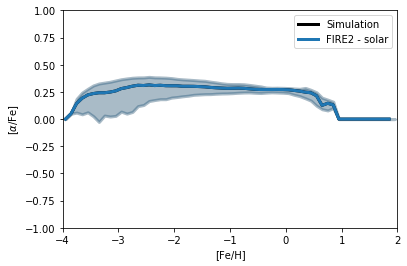

In [25]:
#
# Lets try this out!
#
from utilities.basic.binning import BinClass

fig,ax=plt.subplots()
fig.set_size_inches(6,4)

bc    = BinClass([-4,2],number= int((2-(-4))/0.1))

# plot the native simulation data:
stats = bc.get_statistics_of_array(  part['star'].prop('metallicity.fe'),
                                     part['star'].prop('metallicity.alpha - metallicity.fe'))
    
    
ax.plot(stats['bin.mid'][:-1], stats['median'][:-1], lw=3, color = 'black', label = 'Simulation')
ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                lw = 3, color='black')


# plot the post-processed data.
# this can be done with just the ".agetracers" string, which works
# for all things that the elements work on already (metallicity, mass, massfraction, etc.)
bc    = BinClass([-4,2],number= int((2-(-4))/0.1))
stats2 = bc.get_statistics_of_array(  part['star'].prop('metallicity.agetracers.fe'),
                                     part['star'].prop('metallicity.agetracers.alpha - metallicity.agetracers.fe'))
    
    
ax.plot(stats2['bin.mid'][:-1], stats2['median'][:-1], lw=3, color = 'C0', label = 'FIRE2 - solar')
ax.fill_between(stats2['bin.mid'], stats2['percent.16'], stats2['percent.84'], alpha=0.2,
                lw = 3, color='C0')


ax.legend(loc='best')
ax.set_ylim(-1,1)
ax.set_xlim(-4,2)
ax.set_ylabel(r'[$\alpha$/Fe]')
ax.set_xlabel('[Fe/H]')

In [26]:
stats['mid']

KeyError: 'mid'

In [ ]:
stats2['mid']